# VAE
> https://1drv.ms/p/s!Aigohf1HXs8Uj2CoEgQFiOplWxnZ

In [3]:
from glob import glob

# 決定要把讀進來的照片resize的程度
img_rows = 128
img_cols = 128
channels = 3
img_size = (img_rows, img_cols, channels)
latent_dim = 100
img_path_list = glob('./Preview/cartoon/*.png')

In [18]:
from PIL import Image

def load_data(img_res, path_list):
    def imread(path, img_res):
        # 用 PIL讀圖片
        return np.array(Image.open(path).convert('RGB').resize(img_res, Image.ANTIALIAS)) / 255
        
    img_set = np.zeros((len(path_list), ) + img_res)
    # 根據檔案名稱分次讀圖近來
    for idx, rand_img_path in enumerate(path_list):
        img_set[idx] = imread(rand_img_path, img_res[:2])[:,:,:3]
            
    return img_set

In [19]:
%%time
img_data = load_data(img_size, img_path_list)

Wall time: 53.9 s


ram大概吃4G

In [4]:
from sys import getsizeof
getsizeof(img_data)

3932160144

In [52]:
img_data.shape

(10000, 128, 128, 3)

### Encoder

In [20]:
import keras.backend as K

def build_encoder():
    # sample mean and variance
    def sampling(args):
        z_mu, z_logvar = args
        # K.shape為symbolic shape of a tensor or variable
        batch = K.shape(z_mu)[0]
        dim = K.int_shape(z_mu)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mu + K.exp(0.5 * z_logvar) * epsilon
            
    inputs = Input(shape=img_size, name='encoder_input')        
#     h = Conv2D(16, kernel_size=4, strides=2, padding='same', name='conv1')(inputs)
    h = Conv2D(16, kernel_size=4, padding='same', name='conv1')(inputs)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = LeakyReLU(alpha=0.2)(h)

#     h = Conv2D(32, kernel_size=4, strides=2, padding='same', name='conv2')(h)
    h = Conv2D(32, kernel_size=4, padding='same', name='conv2')(h)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(alpha=0.2)(h)

#     h = Conv2D(64, kernel_size=4, strides=2, padding='same', name='conv3')(h)
    h = Conv2D(64, kernel_size=4, padding='same', name='conv3')(h)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(alpha=0.2)(h)

#     h = Conv2D(128, kernel_size=4, strides=2, padding='same', name='conv4')(h)
    h = Conv2D(128, kernel_size=4, padding='same', name='conv4')(h)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = BatchNormalization()(h)
    h = ReLU()(h)

    h = Flatten()(h)

     # 最後兩層dense代表 mu跟sigma  
    z_mu = Dense(latent_dim, name='z_mu')(h)
    z_logvar = Dense(latent_dim, name='z_logvar')(h)
    # 封裝成layer
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mu, z_logvar])

    return Model(inputs, [z, z_mu, z_logvar], name='encoder')

### Decoder

In [21]:
def build_decoder():
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    h = Reshape((1, 1, latent_dim))(latent_inputs)
    h = Conv2DTranspose(128, kernel_size=4, strides=1, padding='valid', name='convT1')(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(alpha=0.2)(h)

    h = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', name='convT2')(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(alpha=0.2)(h)

    h = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', name='convT3')(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(alpha=0.2)(h)

    h = Conv2DTranspose(16, kernel_size=4, strides=2, padding='same', name='convT4')(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(alpha=0.2)(h)
    
    # 圖片是128*128要多一層 upsampling, (跟encoder的層數不一樣還是可以跑)
    h = Conv2DTranspose(16, kernel_size=4, strides=2, padding='same', name='convT5')(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(alpha=0.2)(h)
    

    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='sigmoid', name='convT6')(h)

    return Model(latent_inputs, outputs, name='decoder')

In [22]:
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Dense, Input, BatchNormalization, Flatten, Lambda, Reshape, LeakyReLU, ReLU, MaxPooling2D

img_input = Input(shape=img_size)
encoder = build_encoder()
encoder.summary()

W0709 22:34:27.365703  9604 deprecation_wrapper.py:119] From c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 16) 784         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 64, 64, 16)   0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2 (Con

In [23]:
decoder = build_decoder()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 50)                0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 1, 1, 50)          0         
_________________________________________________________________
convT1 (Conv2DTranspose)     (None, 4, 4, 128)         102528    
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
convT2 (Conv2DTranspose)     (None, 8, 8, 64)          131136    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 64)          256       
__________

### 連結encoder, decoder

In [24]:
output = decoder(encoder(img_input)[0])
combined = Model(img_input, output, name='vae')
_, z_mu, z_logvar = encoder.get_output_at(-1)
# 計算construction loss
reconstruction_loss = binary_crossentropy(K.flatten(img_input), K.flatten(output))
reconstruction_loss *= img_size[0] * img_size[1] * img_size[2]

kl_loss = 1 + z_logvar - K.square(z_mu) - K.exp(z_logvar)
kl_loss = K.sum(kl_loss, axis=-1) * -.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
combined.add_loss(vae_loss)
combined.compile(optimizer='adam')

W0709 22:34:28.270675  9604 deprecation.py:323] From c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0709 22:34:28.280694  9604 deprecation_wrapper.py:119] From c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### 查看VAE還原能力

In [25]:
def sample_image(iteration):
    r, c = 4, 3
    idx = np.random.choice(len(img_data), r*c, replace=False)
    y = combined.predict(img_data[idx])

    fig, axs = plt.subplots(r, c, figsize=(10,10))
    cnt = 0
    for j in range(r):
        for i in range(c):
            show = np.zeros((img_size[0], img_size[1]*2, img_size[2]))
            show[:,:img_size[1]] = img_data[idx[cnt]]
            show[:,img_size[1]:] = y[cnt]
            axs[j, i].imshow(show)
            axs[j, i].axis('off')
            cnt = cnt+1
    fig.savefig("images/reconst/%d.png" % iteration)
    plt.close()

### Given 常態分佈產生圖

In [26]:
def generate_image(iteration):
    r, c = 4, 4
    z = np.random.standard_normal((r*c, latent_dim))
    gen_img = decoder.predict(z)

    fig, axs = plt.subplots(r, c, figsize=(10,10))
    cnt = 0
    for j in range(r):
        for i in range(c):                
            axs[j, i].imshow(gen_img[cnt])
            axs[j, i].axis('off')
            cnt = cnt+1
    fig.savefig("images/generate/%d.png" % iteration)
    plt.close()

In [27]:
def train(epochs, batch_size):
    history_list = [] 
    for i in range(epochs):
        history_vae = combined.fit(img_data, epochs=1, batch_size=batch_size, verbose=0)
        history_list += history_vae.history['loss']            
        if i % 10 == 0:
            # 印最新一次的loss
            print("[Epoch %d/%d] [VAE loss: %f]" % (i, epochs, history_list[-1]))
            sample_image(i)
            generate_image(i)
            
    show(history_list)

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

def show(history):
    plt.plot(list(range(len(history))), history)
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.title('Learning curve ' + str(batch_size) + ' * '+ str(batch_size))
    plt.savefig('images/learning_curve.png')

In [29]:
import os

batch_size = 100
epochs = 250

if not os.path.exists('images/reconst'):
    os.makedirs('images/reconst')
if not os.path.exists('images/generate'):
    os.makedirs('images/generate')

[Epoch 0/250] [VAE loss: 18128.043965]
[Epoch 10/250] [VAE loss: 6834.034702]
[Epoch 20/250] [VAE loss: 6652.770786]
[Epoch 30/250] [VAE loss: 6584.854341]
[Epoch 40/250] [VAE loss: 6543.133350]
[Epoch 50/250] [VAE loss: 6518.897700]
[Epoch 60/250] [VAE loss: 6490.101743]
[Epoch 70/250] [VAE loss: 6476.072251]
[Epoch 80/250] [VAE loss: 6458.834453]
[Epoch 90/250] [VAE loss: 6447.013589]
[Epoch 100/250] [VAE loss: 6439.507344]
[Epoch 110/250] [VAE loss: 6431.577627]
[Epoch 120/250] [VAE loss: 6422.082446]
[Epoch 130/250] [VAE loss: 6413.958018]
[Epoch 140/250] [VAE loss: 6407.480444]
[Epoch 150/250] [VAE loss: 6401.656587]
[Epoch 160/250] [VAE loss: 6398.969194]
[Epoch 170/250] [VAE loss: 6393.169429]
[Epoch 180/250] [VAE loss: 6396.645825]
[Epoch 190/250] [VAE loss: 6385.811206]
[Epoch 200/250] [VAE loss: 6383.141597]
[Epoch 210/250] [VAE loss: 6383.462612]
[Epoch 220/250] [VAE loss: 6379.095771]
[Epoch 230/250] [VAE loss: 6374.520771]
[Epoch 240/250] [VAE loss: 6372.352510]


TypeError: can only concatenate str (not "int") to str

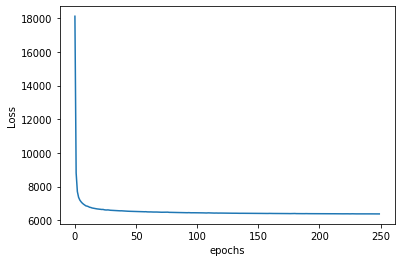

In [30]:
%%time
train(epochs, batch_size)

In [31]:
def generate_morphing_image():
    r, c = 7, 7
    z = np.zeros((r*c, latent_dim))
    z[0] = np.random.standard_normal((1, latent_dim))
    tmp = np.random.standard_normal((1, latent_dim)) - z[0]
    for i in range(1, len(z)):
        z[i] = z[i-1] + tmp / (r*c)      

    gen_img = decoder.predict(z)
    fig, axs = plt.subplots(r, c, figsize=(10,10))
    cnt = 0
    for j in range(r):
        for i in range(c):                
            axs[j, i].imshow(gen_img[cnt])
            axs[j, i].axis('off')
            cnt = cnt+1
    fig.savefig("images/morphing_128_250.png")
    plt.close()
    
generate_morphing_image()